In [124]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

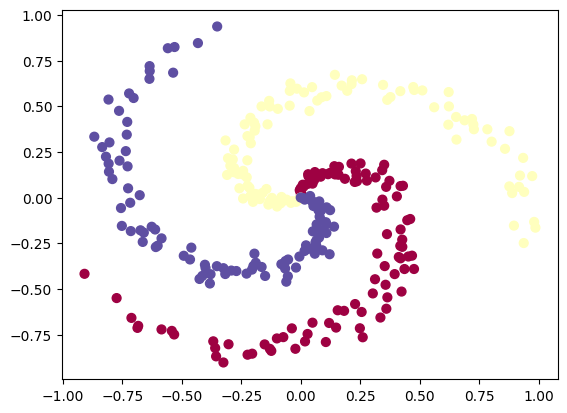

In [125]:
import numpy as np
N = 100
D = 2
K = 3
X_arr = np.zeros((N*K,D))
y_arr = np.zeros(N*K, dtype='uint8')
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N)
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
  X_arr[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y_arr[ix] = j
plt.scatter(X_arr[:, 0], X_arr[:, 1], c=y_arr, s=40, cmap=plt.cm.Spectral)
plt.show()

In [126]:
X=torch.from_numpy(X_arr).type(torch.float)
y=torch.from_numpy(y_arr).type(torch.LongTensor)

In [127]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [128]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [129]:
class Multiclass(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1=nn.Linear(in_features=2, out_features=16)
        self.layer_2=nn.Linear(in_features=16,out_features=16)
        self.layer_3=nn.Linear(in_features=16,out_features=3)
        self.relu=nn.ReLU()
    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model1=Multiclass().to(device)
model1

Multiclass(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
)

In [130]:
def accuracy_function(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=(correct/len(y_pred))*100
    return acc

In [131]:
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model1.parameters(),lr=0.1)

In [132]:
torch.manual_seed(42)
epoches=1500
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epoches):
    model1.train()
    y_log=model1(X_train)
    y_pred=torch.softmax(y_log,dim=1).argmax(dim=1)

    loss=loss_func(y_log,y_train)
    acc=accuracy_function(y_train,y_pred=y_pred)

    optimizer.zero_grad()
    
    loss.backward()

    optimizer.step()

    model1.eval()
    with torch.inference_mode():
        test_log=model1(X_test)
        test_pred=torch.softmax(test_log,dim=1).argmax(dim=1)
        test_loss=loss_func(test_log,y_test)
        test_acc=accuracy_function(y_true=y_test,y_pred=test_pred)
    if epoch%100==0:
        print(f"Eproch: {epoch}, Loss {loss:.5f}, Accuracy:{acc}:2f%  Test Loss: {test_loss:.5f},Test accuracy {test_acc:.2f}%")

Eproch: 0, Loss 1.13753, Accuracy:32.5:2f%  Test Loss: 1.13553,Test accuracy 36.67%
Eproch: 100, Loss 0.88803, Accuracy:67.08333333333333:2f%  Test Loss: 0.92241,Test accuracy 53.33%
Eproch: 200, Loss 0.67826, Accuracy:58.75:2f%  Test Loss: 0.74682,Test accuracy 45.00%
Eproch: 300, Loss 0.61719, Accuracy:63.33333333333333:2f%  Test Loss: 0.69279,Test accuracy 50.00%
Eproch: 400, Loss 0.55151, Accuracy:66.25:2f%  Test Loss: 0.62124,Test accuracy 60.00%
Eproch: 500, Loss 0.47119, Accuracy:73.75:2f%  Test Loss: 0.53003,Test accuracy 70.00%
Eproch: 600, Loss 0.38739, Accuracy:82.08333333333333:2f%  Test Loss: 0.43230,Test accuracy 75.00%
Eproch: 700, Loss 0.31303, Accuracy:87.5:2f%  Test Loss: 0.34562,Test accuracy 86.67%
Eproch: 800, Loss 0.25338, Accuracy:90.0:2f%  Test Loss: 0.27558,Test accuracy 90.00%
Eproch: 900, Loss 0.20883, Accuracy:92.5:2f%  Test Loss: 0.22314,Test accuracy 95.00%
Eproch: 1000, Loss 0.17688, Accuracy:92.91666666666667:2f%  Test Loss: 0.18332,Test accuracy 95.00%


In [133]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

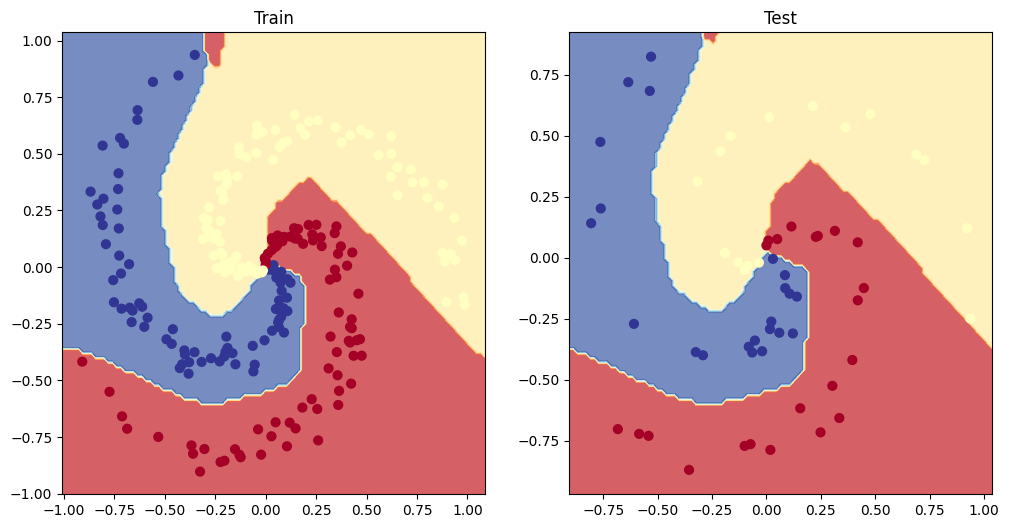

In [134]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)